<a href="https://colab.research.google.com/github/sabir196/sabellas_project/blob/main/hospital_readmissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import io
import pandas as pd

# Upload the zip file
uploaded = files.upload()

# Extract the CSV from the uploaded ZIP
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as zip_ref:
            zip_ref.extractall()  # Extracts in current directory


Saving hospital_readmissions.csv.zip to hospital_readmissions.csv.zip


In [ ]:
# Try reading the CSV with flexible parsing
df = pd.read_csv("hospital_readmissions.csv", encoding='latin1', engine='python')

# Basic preview
print("Shape:", df.shape)
df.head()


Shape: (25000, 17)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [ ]:
# === STEP 3: Clean 'readmitted' and Convert to Binary ===

# Lowercase and strip spaces
df['readmitted_clean'] = df['readmitted'].astype(str).str.strip().str.lower()

# Convert to binary (yes = 1, no = 0)
df['readmitted_binary'] = df['readmitted_clean'].apply(lambda x: 1 if x == 'yes' else 0)

# Preview distribution
print("Readmission distribution (%):")
print(df['readmitted_binary'].value_counts(normalize=True) * 100)


Readmission distribution (%):
readmitted_binary
0    52.984
1    47.016
Name: proportion, dtype: float64


In [ ]:
#  Cleaned Features and Handle Missing

# Dropped unneeded columns
df.drop(columns=['readmitted', 'readmitted_clean'], inplace=True)

# Replaced '?' placeholders with actual NaN
df.replace('?', pd.NA, inplace=True)

# Showed missing values (top 10 columns)
print("Top 10 columns with missing values:")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Previewed remaining columns and types
print("\nData types summary:")
print(df.dtypes.value_counts())


Top 10 columns with missing values:
age                  0
time_in_hospital     0
n_lab_procedures     0
n_procedures         0
n_medications        0
n_outpatient         0
n_inpatient          0
n_emergency          0
medical_specialty    0
diag_1               0
dtype: int64

Data types summary:
object    9
int64     8
Name: count, dtype: int64


In [ ]:
# Encoded Categorical Variables & Define X/y

# Identifed all categorical features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", categorical_cols)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Defined model input (X) and output (y)
X = df_encoded.drop(columns='readmitted_binary')
y = df_encoded['readmitted_binary']

# Confirmed shapes and class balance
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True) * 100)


Categorical columns to encode: ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
X shape: (25000, 45)
y distribution:
readmitted_binary
0    52.984
1    47.016
Name: proportion, dtype: float64


In [ ]:
# Baselined Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialized and trained the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predicted on test set
y_pred = logreg.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2083  575]
 [1374  968]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.78      0.68      2658
           1       0.63      0.41      0.50      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.59      5000
weighted avg       0.61      0.61      0.60      5000



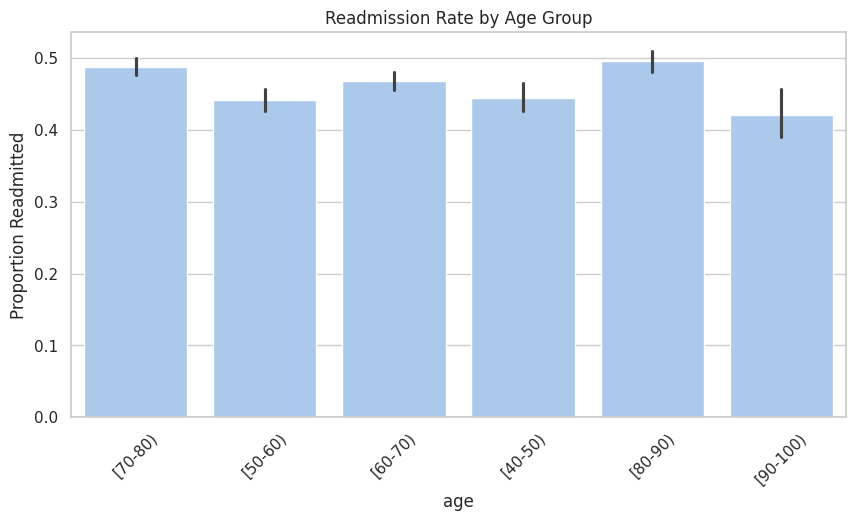

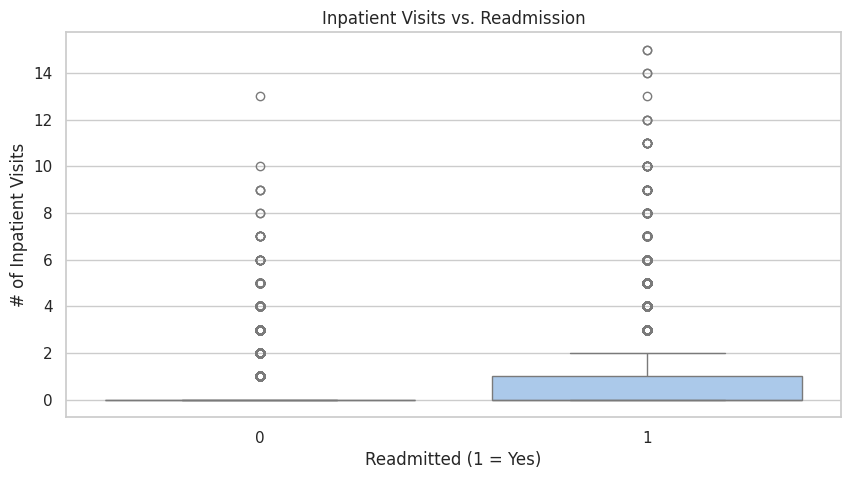

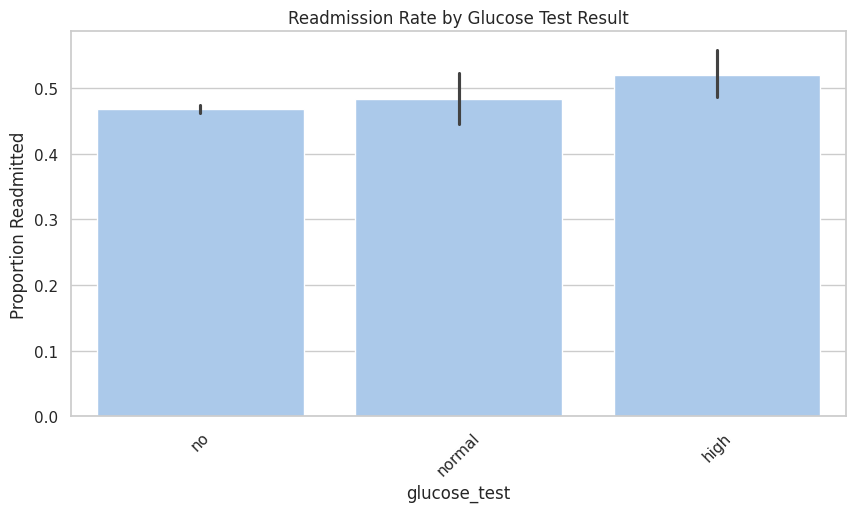

In [ ]:
# Exploratory Data Analysis (EDA) ===

import seaborn as sns
import matplotlib.pyplot as plt

# Set up clean theme
sns.set(style="whitegrid", palette="pastel")

# Plot: Readmission rate by age group
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='age', y='readmitted_binary', estimator=lambda x: sum(x)/len(x))
plt.title("Readmission Rate by Age Group")
plt.ylabel("Proportion Readmitted")
plt.xticks(rotation=45)
plt.show()

# Plot: Readmission by number of inpatient visits
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='readmitted_binary', y='n_inpatient')
plt.title("Inpatient Visits vs. Readmission")
plt.xlabel("Readmitted (1 = Yes)")
plt.ylabel("# of Inpatient Visits")
plt.show()

# Plot: Glucose test result impact
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='glucose_test', y='readmitted_binary', estimator=lambda x: sum(x)/len(x))
plt.title("Readmission Rate by Glucose Test Result")
plt.ylabel("Proportion Readmitted")
plt.xticks(rotation=45)
plt.show()


 Observation: Patients aged 80-90 have the highest readmission rate (~50%). Meanwhile, the lowest rate occurs in patients aged 90+.
This suggests a non-linear relationship between age and readmission risk — worth further exploration.


/tmp/ipython-input-11-254363136.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='coolwarm')
/tmp/ipython-input-11-254363136.py:47: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


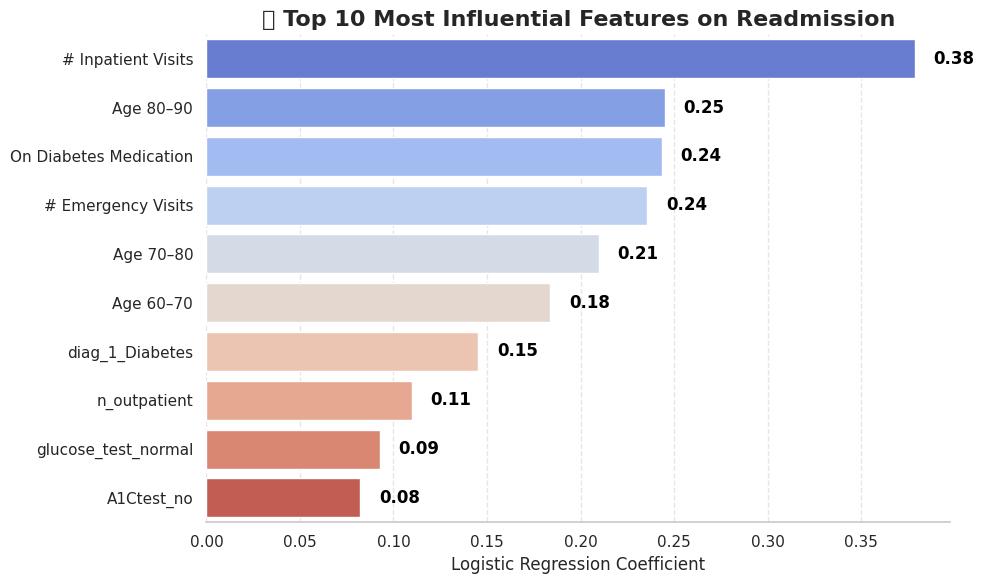

,Feature,Coefficient
5,# Inpatient Visits,0.378800
10,Age 80–90,0.245013
44,On Diabetes Medication,0.243393
6,# Emergency Visits,0.235579
9,Age 70–80,0.209697
8,Age 60–70,0.183799
18,diag_1_Diabetes,0.145372
4,n_outpatient,0.109880
40,glucose_test_normal,0.092609
41,A1Ctest_no,0.082250


In [ ]:
# 💡 Importance from Logistic Regression

# Get feature names and coefficients
feature_names = X.columns
coefs = logreg.coef_[0]

# Combine into DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

# Map cryptic feature names to human-friendly labels
rename_map = {
    'diag_3_Missing': 'Missing Diagnosis 3',
    'n_inpatient': '# Inpatient Visits',
    'age_[80-90)': 'Age 80–90',
    'diabetes_med_yes': 'On Diabetes Medication',
    'n_emergency': '# Emergency Visits',
    'medical_specialty_Surgery': 'Surgery Specialty',
    'age_[70-80)': 'Age 70–80',
    'diag_3_Injury': 'Diagnosis 3 = Injury',
    'age_[60-70)': 'Age 60–70',
    'diag_2_Injury': 'Diagnosis 2 = Injury'
}
coef_df['Feature'] = coef_df['Feature'].replace(rename_map)

# Sort by coefficient (most positive to most negative)
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)
top_features = coef_df_sorted.head(10)

# 🎨 Plot: Top 10 most influential features
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='coolwarm')

# Add inline annotations
for i, coef in enumerate(top_features['Coefficient']):
    ax.text(coef + 0.01 if coef > 0 else coef - 0.05, i, f'{coef:.2f}',
            color='black', va='center', fontweight='bold')

# Aesthetic formatting
plt.title("🔍 Top 10 Most Influential Features on Readmission", fontsize=16, weight='bold')
plt.xlabel("Logistic Regression Coefficient", fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True)
plt.tight_layout()
plt.show()

# 🧾 Table with raw coefficient values
top_features[['Feature', 'Coefficient']]


📊 Random Forest - Confusion Matrix:
[[1845  813]
 [1155 1187]]

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      2658
           1       0.59      0.51      0.55      2342

    accuracy                           0.61      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.61      0.60      5000



/tmp/ipython-input-12-2832963828.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='crest')
/tmp/ipython-input-12-2832963828.py:57: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


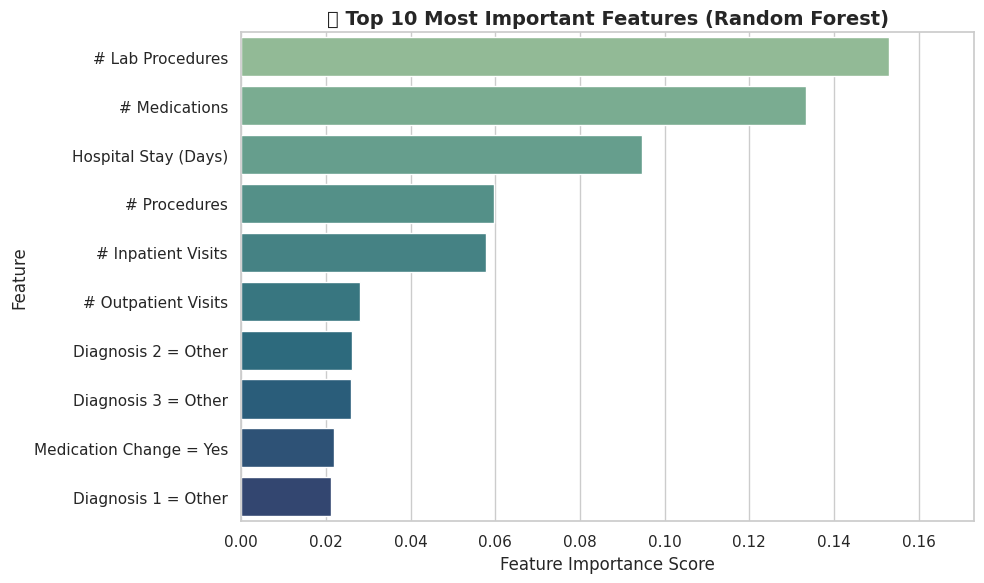

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("📊 Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature Importance DataFrame
importances = rf_model.feature_importances_
feature_names = X.columns

# Map technical names to cleaner ones
feature_name_map = {
    'n_lab_procedures': '# Lab Procedures',
    'n_medications': '# Medications',
    'time_in_hospital': 'Hospital Stay (Days)',
    'n_procedures': '# Procedures',
    'n_inpatient': '# Inpatient Visits',
    'n_outpatient': '# Outpatient Visits',
    'diag_1_Other': 'Diagnosis 1 = Other',
    'diag_2_Other': 'Diagnosis 2 = Other',
    'diag_3_Other': 'Diagnosis 3 = Other',
    'change_yes': 'Medication Change = Yes'
}

# Apply clean labels (fallback to original if not mapped)
pretty_names = [feature_name_map.get(f, f) for f in feature_names]

# Create dataframe
feature_importance_df = pd.DataFrame({
    'Feature': pretty_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='crest')
plt.title("🌲 Top 10 Most Important Features (Random Forest)", fontsize=14, weight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.xlim(0, feature_importance_df['Importance'].max() + 0.02)



plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from google.colab import files

# 1. Top 10 features from Random Forest
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
top_rf = feature_importance_df.head(10)

# 2. Top 10 features from Logistic Regression
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
top_lr = coef_df.head(10)

# 3. Add predictions to export
X_test_copy = X_test.copy()
X_test_copy['actual_readmitted'] = y_test
X_test_copy['predicted_readmitted'] = rf_model.predict(X_test)
X_test_copy['probability_readmitted'] = rf_model.predict_proba(X_test)[:, 1].round(4)

# 4. Save files
top_rf.to_csv("top_features_random_forest.csv", index=False)
top_lr.to_csv("top_features_logistic_regression.csv", index=False)
X_test_copy.to_csv("rf_predictions_output.csv", index=False)

# 5. Download them
files.download("top_features_random_forest.csv")
files.download("top_features_logistic_regression.csv")
files.download("rf_predictions_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>